#### RNN with LSTMs Language Model using Skip-Gram Dense Embeddings

In [107]:
# imports 
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from collections import Counter 
from itertools import chain

import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional


import utils

In [108]:
# constants 
SENTENCE_BEGIN = "<s>"
SENTENCE_END = "</s>"
PADDING = "<pad>"
UNK = "<unk>"

# hyperparameters - may change 
EMBEDDINGS_SIZE = 100
BATCH_SIZE = 128
SEQUENCE_LENGTH = 10

# may either be country or metal
GENRE = 'country' 

# change to save a newly trained model
SAVE_PATH = 'foo'
SHOULD_SAVE = False 

# change to load in an already trained model for sequence generation 
LOAD_PATH = 'country_lstm_model_epoch20_full'
SHOULD_LOAD = False 

In [220]:
# read in cleaned data
if GENRE == 'country':
    train_lines = pd.read_csv('data/country_train.csv', header=None)[0].tolist()
    val_lines = pd.read_csv('data/country_val.csv', header=None)[0].tolist()
    test_lines = pd.read_csv('data/country_test.csv', header=None)[0].tolist()

elif GENRE == 'metal':
    train_lines = pd.read_csv('data/metal_train.csv', header=None)[0].tolist()
    val_lines = pd.read_csv('data/metal_val.csv', header=None)[0].tolist()
    test_lines = pd.read_csv('data/metal_test.csv', header=None)[0].tolist()

else:
    raise ValueError('Incorrect genre given.')


print("Number of training lines:", len(train_lines))
print("Number of validation lines:", len(val_lines))
print("Number of test lines:", len(test_lines))
print('Lyric Example:', train_lines[0])

Number of training lines: 149771
Number of validation lines: 18610
Number of test lines: 19108
Lyric Example: i've seen how you tremble whenever he walks through your mind


#### Data Preparation: Tokenize Lyrics, Pad Sequences, Create Dense Word Embeddings

In [221]:
# tokenize and add a single sentence start and end token around each sequence 
train_tokens = [utils.tokenize_line(line, ngram=1) for line in train_lines] 
val_tokens = [utils.tokenize_line(line, ngram=1) for line in val_lines] 
test_tokens = [utils.tokenize_line(line, ngram=1) for line in test_lines] 

Mean Length: 10.021025432159764
Median Length: 10.0
90th Percentile Length: 15.0
Max Length: 246


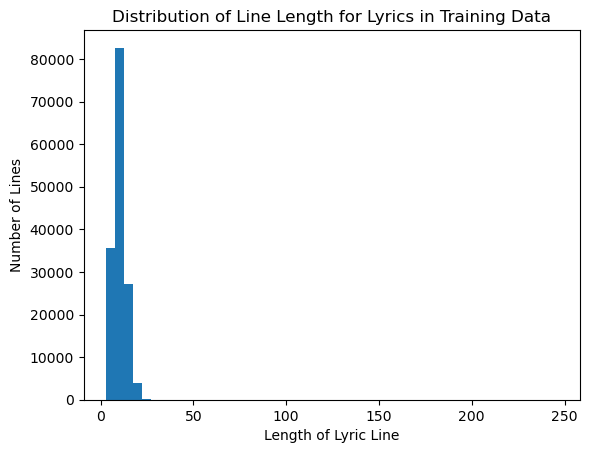

In [111]:
# plot lengths of lyric lines to help determine an appropriate length to pad/truncate to
train_sequence_lengths = [len(seq) for seq in train_tokens]

print("Mean Length:", np.mean(train_sequence_lengths))
print("Median Length:", np.median(train_sequence_lengths))
print("90th Percentile Length:", np.percentile(train_sequence_lengths, 90))
print("Max Length:", np.max(train_sequence_lengths))

plt.hist(train_sequence_lengths, bins=50)
plt.xlabel("Length of Lyric Line")
plt.ylabel("Number of Lines")
plt.title("Distribution of Line Length for Lyrics in Training Data")
plt.show()

In [112]:
def adjust_sequence_length(tokenized_seqs: list, sequence_length: int = SEQUENCE_LENGTH) -> list:
    """
    Pads or truncates all sequences in the provided list to the same length. 
    Adds padding tokens to the left for too-short sequences and truncates to the right 
    for too-long sequences (method based on experimentation with left/right padding/truncation)

    Args:
        tokenized_seqs (list): A list of lists of tokens. Each inner list represents a sequence with tokens as elements
        sequence_length (int): The desired length for all of the sequences
        padding_token (str): The token that should be used to pad short sequences to the proper length

    Returns:
        size_adjusted_sequences (list): A list of lists of tokens, where each inner list is the same length
    """
    size_adjusted_sequences = []
    for sequence in tokenized_seqs:
        if len(sequence) < sequence_length:
            # too short, add padding
            num_padding = sequence_length - len(sequence)
            size_adjusted_sequences.append( ([PADDING] * num_padding) + sequence)
        else:
            # truncate sequences longer than the chosen length 
            size_adjusted_sequences.append(sequence[:sequence_length - 1] + [SENTENCE_END])
            

    return size_adjusted_sequences


def replace_unknowns_train(tokenized_seqs: list) -> list:
    """"
    Replaces words that occur only once with an UNK token

    Args:
        tokenized_seqs (list): A list of lists of tokens. Each inner list represents a sequence with tokens as elements

    Returns:
        Tokenized sequences with low frequency words replaced with the unknown special token 
    """
    # concatenate all sequences together 
    all_tokens = list(chain(*tokenized_seqs))
    token_counts = Counter(all_tokens)

    # Replace words with low frequencies to UNK so that we can calculate perplexity on test data with unknown words 
    cleaned_tokenized_seqs = []
    for seq in tokenized_seqs:
        cleaned_seq = [tok if token_counts[tok] > 1 else UNK for tok in seq]
        cleaned_tokenized_seqs.append(cleaned_seq)

    return cleaned_tokenized_seqs


size_adjusted_sequences_train = adjust_sequence_length(train_tokens)
cleaned_sequences_train = replace_unknowns_train(size_adjusted_sequences_train)
print("Number of sequences:", len(cleaned_sequences_train))
print("Length of Sequences:", len(cleaned_sequences_train[0]))

Number of sequences: 149771
Length of Sequences: 10


In [113]:
# Use Tokenizer to map each token to a unique index 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned_sequences_train)
encoded_sequences_train = tokenizer.texts_to_sequences(cleaned_sequences_train)

print("Vocab Size:", len(tokenizer.word_index))
print('encoded examples:', '\n', encoded_sequences_train[0], '\n', encoded_sequences_train[1])

Vocab Size: 10293
encoded examples: 
 [2, 4, 45, 305, 77, 6, 4389, 1040, 36, 3] 
 [2, 4067, 49, 1312, 15, 1111, 49, 27, 151, 3]


In [114]:
# create word embeddings using skip gram algorithm
word_embeddings = Word2Vec(sentences=cleaned_sequences_train, vector_size=EMBEDDINGS_SIZE, window=5, sg=1, min_count=1)
print('Vocab size for word embeddings:', len(word_embeddings.wv))

Vocab size for word embeddings: 10293


In [115]:
# Function that gives mappings from words to their embeddings and  
# indexes from the tokenizers to their embeddings

def map_embeddings(embeddings: Word2Vec, tokenizer: Tokenizer) -> (dict, dict):
    ''' Creates mappings between different token representations 
    Arguments:
        embeddings: Word2Vec word embeddings for the data (maps tokens to embedding vectors)
        tokenizer: Tokenizer used to tokenize the data (maps token to index)
    Returns:
        (dict): mapping from word to its embedding vector
        (dict): mapping from index to its embedding vector
    '''
    # initialize dictionaries 
    token_to_embedding = {}
    index_to_embedding = {}

    # tokenizer maps tokens to unique indices 
    for token, index in tokenizer.word_index.items():
        embedding = embeddings[token]

        token_to_embedding[token] = embedding
        index_to_embedding[index] = embedding

    return (token_to_embedding, index_to_embedding)


token_to_embedding, index_to_embedding = map_embeddings(word_embeddings.wv, tokenizer)

# Fill in unused index zero to avoid dimension mismatch
index_to_embedding[0] = [0] * EMBEDDINGS_SIZE

#### Generate Samples for Training

In [116]:
def data_generator(data: list, num_sequences_per_batch: int, index_2_embedding: dict) -> (np.array, np.array):
    '''
    Returns a data generator to train the neural network in batches

    X data will be represented in embedding form.
    Y data will be represented with one hot vectors. 

    Args:
    data (list of lists): tokenized sequences represented by their unique index encodings 
    num_sequences_per_batch (int): batch size yielded on each iteration of the generator 
    index_2_embedding (dict): mapping between unique token indices and dense word embeddings 

    Returns:
    X_batch_embeddings (3-D numpy array): sequences of embeddings with dimensions (batch size, num timesteps, embedding size)
                                          Take the first (SEQUENCE_LENGTH - 1) tokens of each sequence
    y_batch (3-D numpy array): sequences of one hot vectors with dimensions (batch size, num timesteps, vocab size)
                                          Take the last (SEQUENCE_LENGTH - 1) tokens of each sequence 
                                          (X shifted forward one token so that the neural net predicts 
                                          the next word in the sequence for each timestep)
    '''
    # iterate over data in batches - stored in the form of unique token indices 
    i = 0
    while True:
        # get samples that we'd like to train on for this batch 
        data_batch = data[i:i+num_sequences_per_batch]

        # increment i with each batch 
        i += num_sequences_per_batch

        # split into X and Y -- shifted sequence so that for each timestep, Y is the token that follows X 
        X_data = [sequence[:-1] for sequence in data_batch]
        Y_data = [sequence[1:] for sequence in data_batch]
        if i < 300:
            print("X")
            print(X_data[:5])
            print("Y")
            print(Y_data[:5])


        # get embeddings for X data 
        X_embeddings = []
        for X_sequence in X_data:
            X_sequence_embeddings = [index_2_embedding[token_idx] for token_idx in X_sequence]
            X_embeddings.append(X_sequence_embeddings)

        # get one hot vectors for Y data 
        Y_one_hot_vectors = []
        for Y_sequence in Y_data:
            Y_one_hot = to_categorical(Y_sequence, num_classes=len(index_2_embedding))
            Y_one_hot_vectors.append(Y_one_hot)

        # yield statement instead of return for generator 
        yield(np.array(X_embeddings), np.array(Y_one_hot_vectors))


# demo the data generator
demo_data_generator = data_generator(encoded_sequences_train, BATCH_SIZE, index_to_embedding)
demo_sample = next(demo_data_generator)
print("X batch shape:", demo_sample[0].shape)
print("y batch shape:", demo_sample[1].shape)


X
[[2, 4, 45, 305, 77, 6, 4389, 1040, 36], [2, 4067, 49, 1312, 15, 1111, 49, 27, 151], [2, 82, 5, 198, 19, 115, 24, 1182, 10], [2, 4, 41, 15, 36, 340, 6, 7, 340], [2, 58, 4, 489, 658, 77, 10, 154, 6]]
Y
[[4, 45, 305, 77, 6, 4389, 1040, 36, 3], [4067, 49, 1312, 15, 1111, 49, 27, 151, 3], [82, 5, 198, 19, 115, 24, 1182, 10, 3], [4, 41, 15, 36, 340, 6, 7, 340, 3], [58, 4, 489, 658, 77, 10, 154, 6, 3]]
X batch shape: (128, 9, 100)
y batch shape: (128, 9, 10294)


In [222]:
# prepare validation data -- unknown words determined by training vocabulary 
def encode_val_sequences(tokenized_seqs: list, tokenizer) -> list:
    """"
    Replaces words that are not in the tokenizer's vocab with the unknown special token and encodes it to 
    unique token indices specified by the provided Tokenizer.

    Args:
        tokenized_seqs (list): A list of lists of tokens. Each inner list represents a sequence with tokens as elements
        tokenizer: Tokenizer used maps token to index

    Returns:
        Encoded sequences with words not in the training vocabulary replaced with the unknown special token 
    """
    cleaned_tokenized_seqs = []
    for seq in tokenized_seqs:
        cleaned_seq = [tok if tok in tokenizer.word_index.keys() else UNK for tok in seq]
        cleaned_tokenized_seqs.append(cleaned_seq)

    return tokenizer.texts_to_sequences(cleaned_tokenized_seqs)

#size_adjusted_sequences_val = adjust_sequence_length(val_tokens)
#encoded_sequences_val = encode_val_sequences(size_adjusted_sequences_val, tokenizer)
encoded_sequences_val = encode_val_sequences(val_tokens, tokenizer)

In [118]:
import numpy as np
from keras.callbacks import Callback
from keras import backend as K

# TODO - likely delete 
# chatgpt code when asked "how can I print perplexity with each epoch of a keras model"
class PerplexityCallback(Callback):
    def __init__(self, validation_data):
        super(PerplexityCallback, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data
        y_pred = self.model.predict(x_val)
        cross_entropy = -np.sum(np.log(np.clip(y_pred, 1e-10, 1.0)) * y_val) / len(y_val)
        perplexity = np.exp(cross_entropy)
        print(f'\nPerplexity on validation data after epoch {epoch + 1}: {perplexity:.4f}')


#### Create and Train Model

In [119]:
def lstm_rnn(train_data: np.array,
             val_data: np.array, 
             index_2_embedding: dict, 
             num_epochs: int=1, 
             num_sequences_per_batch: int=BATCH_SIZE, 
             sequence_length: int=SEQUENCE_LENGTH,
             embedding_size: int=EMBEDDINGS_SIZE):
    """
    Creates and trains an RNN with LSTM cells using given training data and batch size.

    Args:
        train_data (list of lists): encoded sequences of training data represented by token indices 
        train_data (list of lists): encoded sequences of validation data represented by token indices 
        index_2_embedding (dict): mapping from token index -> word2vec embeddings 
        num_epochs (int): number of training epochs
        num_sequences_per_batch (int): batch size for training data 
        sequence_length (int): number of tokens in each training sample 
        embedding_size (int): size of the dense word embeddings used to represent tokens 
    Returns:
        A trained Neural Network language model
    """
    # define model parameters
    hidden_units = 200
    hidden_input_dim = (sequence_length - 1, embedding_size)      # (number of steps, number of features per step)
    output_dim = len(index_2_embedding)                            # vocab size 

    # instantiate model
    model = Sequential()


    # hidden layer
    model.add(Bidirectional(LSTM(hidden_units, 
                                 input_shape=hidden_input_dim,
                                 return_sequences=True)))

    # output layer
    model.add(Dense(units=output_dim, activation='softmax'))

    # configure the learning process
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=["top_k_categorical_accuracy"])
    
    # total number of batches per epoch 
    steps_per_epoch = len(train_data)//num_sequences_per_batch
    steps_per_epoch_val = len(val_data)//num_sequences_per_batch

 
   
    for i in range(num_epochs):
        if i % 5 == 0:
            print("Epoch", i)

        # create a new data generator for us to iterate through
        train_generator = data_generator(train_data, num_sequences_per_batch, index_2_embedding)
        val_generator = data_generator(val_data, num_sequences_per_batch, index_2_embedding)

        # train model 
        model.fit(x=train_generator, steps_per_epoch=steps_per_epoch, validation_data=val_generator, validation_steps=steps_per_epoch_val)

    model.summary()
    return model

In [120]:
model = lstm_rnn(np.array(encoded_sequences_train), np.array(encoded_sequences_val), index_to_embedding, num_epochs=20)

# save trained model 
if SHOULD_SAVE:
    model.save(SAVE_PATH)

Epoch 0
X
[array([   2,    4,   45,  305,   77,    6, 4389, 1040,   36]), array([   2, 4067,   49, 1312,   15, 1111,   49,   27,  151]), array([   2,   82,    5,  198,   19,  115,   24, 1182,   10]), array([  2,   4,  41,  15,  36, 340,   6,   7, 340]), array([  2,  58,   4, 489, 658,  77,  10, 154,   6])]
Y
[array([   4,   45,  305,   77,    6, 4389, 1040,   36,    3]), array([4067,   49, 1312,   15, 1111,   49,   27,  151,    3]), array([  82,    5,  198,   19,  115,   24, 1182,   10,    3]), array([  4,  41,  15,  36, 340,   6,   7, 340,   3]), array([ 58,   4, 489, 658,  77,  10, 154,   6,   3])]
X
[array([  1,   1,   2,   4, 108,   6,  10, 312,  13]), array([ 1,  1,  1,  1,  1,  2, 48, 24, 34]), array([ 1,  1,  1,  1,  1,  2, 48, 24, 34]), array([   1,    1,    1,    1,    2,   70,   67,   17, 1786]), array([  1,   1,   1,   1,   2, 403,  13, 419, 358])]
Y
[array([  1,   2,   4, 108,   6,  10, 312,  13,   3]), array([ 1,  1,  1,  1,  2, 48, 24, 34,  3]), array([ 1,  1,  1,  1,  2,

In [121]:
#model_test = lstm_rnn(np.array(encoded_sequences_train), np.array(encoded_sequences_val), index_to_embedding, num_epochs=20)

#### Create functions to generate new sequences 

In [164]:
def generate_sequences(model: Sequential, 
                      tokenizer: Tokenizer, 
                      index_2_embedding: dict, 
                      num_seq: int):
    '''
    Generates a given number of sequences using the given RNN language model.
    Will begin the sequence generation with n-1 SENTENCE_BEGIN tokens.
    Returned sequences will have the BEGIN, END, and PADDING tokens removed

    Args:
        model: RNN language model
        tokenizer: the keras preprocessing tokenizer
        index_2_embedding: mapping from token index -> word2vec embeddings 
        num_seq: the number of sequences to generate 

    Returns: 
        A list of strings, where each string is a generated sequence with special tokens removed 
    '''
    seed = [SENTENCE_BEGIN] * (SEQUENCE_LENGTH - 1) 
    
    sequences = []
    for _ in range(num_seq):
        seq = generate_seq(model, tokenizer, index_2_embedding, seed)
        seq = ' '.join(seq)

        # remove special tokens
        seq = seq.replace(SENTENCE_BEGIN, '')
        seq = seq.replace(SENTENCE_END, '')
        seq = seq.replace(PADDING, '')

        sequences.append(seq.strip())
        
    return sequences

def generate_seq(model: Sequential, 
                 tokenizer: Tokenizer, 
                 index_2_embedding: dict, 
                 seed: list):
    '''
    Generates a single sequence using the given model starting with a SENTENCE_BEGIN and ending with a SENTENCE_END token. 
    Since an RNN takes input sequences of fixed length, use a sliding window to continually predict the next word. 

    Args:
        model: RNN language model
        tokenizer: the keras preprocessing tokenizer
        index_2_embedding: mapping from token index -> word2vec embeddings 
        seed: the initial tokens to feed the RNN
    Returns: 
        An array of tokens representing a sequence 
    '''
    padding_index = tokenizer.word_index.get(PADDING)
    sentence_begin_index = tokenizer.word_index.get(SENTENCE_BEGIN)
    sentence_end_index = tokenizer.word_index.get(SENTENCE_END)

    # track the unique token indices for the sequence 
    sequence_indices = [tokenizer.word_index.get(tok) for tok in seed] 

    input_length = SEQUENCE_LENGTH - 1

    # until we get a SENTENCE_END token
    while sequence_indices[-1] != sentence_end_index:
        # get latest tokens to use as inputs 
        input_sequence = sequence_indices[-1*input_length:]

        # convert the input sequence to embeddings
        input_embeddings = np.array([[index_2_embedding[idx] for idx in input_sequence]])

        # get probability distribution on vocabulary for the next token in the sequence 
        prediction = model.predict(input_embeddings, verbose=False)[0][-1]

        # sample from the probability distribution 
        next_tok_idx = np.random.choice(len(prediction), p=prediction)

        # skip mid-sentence SENTENCE_BEGIN and PADDING tokens
        if next_tok_idx == sentence_begin_index or next_tok_idx == padding_index:
            continue

        # add newly generated token to our sequence 
        sequence_indices.append(next_tok_idx)

    # convert to words 
    tokenizer_words = list(tokenizer.word_index.keys())
    tokenizer_indices = list(tokenizer.word_index.values())
    sequence = [tokenizer_words[tokenizer_indices.index(idx)] for idx in sequence_indices]
    return sequence

In [196]:
# load in model 
if SHOULD_LOAD:
    model = keras.saving.load_model(LOAD_PATH)
    
# Generate new lyrics 
generated_sequences = generate_sequences(model, tokenizer, index_to_embedding, num_seq=10)
print("Sample Generated Lyrics:\n")
for seq in generated_sequences:
    print(seq)

Sample Generated Lyrics:


realizing a-paintin civilzed cc parkin´ cornography
nancy freckle life
you-ooo-ooo hinges
youâ€™re jamaican fold peasant ba hughes
hypocrite froze chewed teardrops sanders flatnin

security anne paisley/chris |d burch hughes
wages buisness ronald le-ee prepares hughes
oh-oh-oh-oh-oh-oh-oh cheatinâ€™ linda evans/marcus evans/billy pickle


In [197]:

other_model = keras.saving.load_model("country_lstm_model_epoch20_full")
    
# Generate new lyrics 
generated_sequences = generate_sequences(other_model, tokenizer, index_to_embedding, num_seq=10)
print("Sample Generated Lyrics:\n")
for seq in generated_sequences:
    print(seq)

Sample Generated Lyrics:

] broken on and ] ? save anytime heard
here who
arms going
tears to than
little going
on you
dance wild at angel
together a another little together
merle
come like smile


#### Calculate Perplexity 


In [202]:
def median_perplexity(model, val_data: np.array):
    padding_index = tokenizer.word_index.get(PADDING)
    sentence_begin_index = tokenizer.word_index.get(SENTENCE_BEGIN)

    perplexities = []
    # iterate through each encoded validation sequence 
    for seq in val_data[:2000]: 
        # shift Y forward one token to represent the next word predictions 
        X_data = seq[:-1] 
        Y_data = seq[1:]

        # get word embeddings for X as input to the model
        X_sequence_embeddings = np.array([[index_to_embedding[token_idx] for token_idx in X_data]])

        # get predictions - represented as softmax probabilities over the vocabulary 
        Y_prob_softmax = model.predict(X_sequence_embeddings, verbose=0)

        N = 0
        Y_pred_log_prob = 0
        for i, y in enumerate(Y_data):
            # 0 to get the only row in the batch, i to get the ith token prediction, 
            # y to get the predicted probability of the true value 
            y_pred_prob = Y_prob_softmax[0][i][y] 
            print(y_pred_prob)

            Y_pred_log_prob += np.log(y_pred_prob)

            # only include meaningful tokens in our token count 
            if y != padding_index and y != sentence_begin_index:
                N += 1
                
        Y_pred_prob = np.exp(Y_pred_log_prob)
        perplexity = Y_pred_prob ** (-1/N)
        perplexities.append(perplexity)

    return np.median(perplexities)

median_perplexity(model, encoded_sequences_val)



NEXT TOKEN: 0 6
[1.8620700e-15 6.5978294e-13 4.8071051e-15 4.9037073e-17 4.2228405e-11
 1.1271773e-15 1.0000000e+00 7.3648789e-16]
NEXT TOKEN: 1 22
[7.3524127e-16 1.8089860e-13 1.0729826e-14 7.8663828e-16 6.2396567e-14
 1.0344933e-16 1.2363660e-12 2.8914117e-14 7.1720413e-10 2.0807978e-19
 1.5114801e-15 3.1071078e-17 7.3638585e-14 1.5574241e-18 2.3718086e-19
 2.1393894e-15 1.2925802e-09 1.1260799e-17 5.2255038e-14 8.8145180e-20
 1.1429327e-16 1.1515542e-12 9.9999964e-01 5.7392899e-14]


ValueError: operands could not be broadcast together with shapes (8,) (24,) (8,) 

In [226]:
def calculate_perplexity(encoded_sequence: list, model: Sequential, 
                        tokenizer: Tokenizer, 
                        index_2_embedding: dict):
    '''
    
    Args:
        model: RNN language model
        tokenizer: the keras preprocessing tokenizer
        index_2_embedding: mapping from token index -> word2vec embeddings 
        seed: the initial tokens to feed the RNN
    Returns: 
        An array of tokens representing a sequence 
    ''' 
    padding_index = tokenizer.word_index.get(PADDING)
    sentence_begin_index = tokenizer.word_index.get(SENTENCE_BEGIN)
    #encoded_sequence = encoded_sequence[:11]
    # shift Y forward one token to represent the next word predictions 
    X_data = encoded_sequence[:-1]
    Y_data = encoded_sequence[1:]
    #print(encoded_sequence)

    # seed with SEQUENCE_LENGTH - 2 sentence begins (first token in X is a sentence begin as well),
    # inch window along to predict the next word 
    encoded_input = [sentence_begin_index] * (SEQUENCE_LENGTH - 2) + X_data

    input_length = SEQUENCE_LENGTH - 1

    # we will be finding the log of the probability of our model generating this sequence 
    Y_pred_log_prob = 0

    # track the number of meaningful tokens 
    N = 0

    # until we get a SENTENCE_END token
    for i, y in enumerate(Y_data):
        # use a sliding window over the input, where the input sequence are the tokens preceeding y 
        input_sequence = encoded_input[i:input_length+i]

        #print(input_sequence)
        #print(y)

        # convert the input sequence to embeddings
        input_embeddings = np.array([[index_2_embedding[idx] for idx in input_sequence]])

        # get probability distribution on vocabulary for the next token in the sequence 
        prediction = model.predict(input_embeddings, verbose=False)[0][-1]

        # index y to get the predicted probability of the true value 
        y_pred_prob = prediction[y] 
        #print(y_pred_prob)

        Y_pred_log_prob += np.log(y_pred_prob)

        # only include meaningful tokens in our token count 
        if y != padding_index and y != sentence_begin_index:
            N += 1

    Y_pred_prob = np.exp(Y_pred_log_prob)
    perplexity = Y_pred_prob ** (-1/N)
    if perplexity > 1000000:
        tokenizer_words = list(tokenizer.word_index.keys())
        tokenizer_indices = list(tokenizer.word_index.values())
        sequence = [tokenizer_words[tokenizer_indices.index(idx)] for idx in encoded_sequence]
        print(sequence)
    return perplexity


def median_perplexity(val_data: np.array, model: Sequential, 
                        tokenizer: Tokenizer, 
                        index_2_embedding: dict):
    perplexities = []
    for seq in val_data:
        perplexities.append(calculate_perplexity(seq, model, tokenizer, index_2_embedding))
    return np.mean(perplexities)

#calculate_perplexity(encoded_sequences_val[2], model, tokenizer, index_to_embedding)
median_perplexity(encoded_sequences_val[:200], model, tokenizer, index_to_embedding)

['<s>', 'you', 'do', "n't", 'know', 'what', "'s", 'good', 'for', 'you', 'you', 'wo', "n't", 'leave', 'me', 'alone', '</s>']
['<s>', 'do', "n't", 'make', 'me', 'go', 'out', 'off', 'my', 'way', 'do', "n't", 'tempt', 'me', 'please', '</s>']
['<s>', 'do', "n't", 'you', 'be', 'so', 'nice', 'to', 'me', 'i', 'fall', 'in', 'love', 'so', 'easily', '</s>']
['<s>', 'but', 'the', 'things', 'you', 'make', 'me', 'want', 'to', 'do', 'i', "'ll", 'regret', 'i', 'know', '</s>']
['<s>', 'so', 'do', "n't", 'say', 'things', 'that', 'you', 'do', "n't", 'mean', 'cause', 'i', 'just', 'might', 'believe', '</s>']
['<s>', 'do', "n't", 'you', 'be', 'so', 'nice', 'to', 'me', 'i', 'fall', 'in', 'love', 'so', 'easily', '</s>']
['<s>', 'i', "'m", 'gon', 'na', 'leave', 'tonight', 'with', 'you', 'go', 'on', 'and', 'have', 'your', 'fun', '</s>']
['<s>', 'i', 'do', "n't", 'want', 'to', 'be', 'a', 'part', 'of', 'what', 'i', 'might', 'have', 'done', '</s>']
['<s>', 'i', "'m", 'tempted', 'when', 'i', 'think', 'about', 'the'

1071925.5555973738

In [125]:
# e ** cross entropy loss
def median_perplexity2(model, val_data: np.array):
    padding_index = tokenizer.word_index.get(PADDING)
    sentence_begin_index = tokenizer.word_index.get(SENTENCE_BEGIN)

    perplexities = []
    # iterate through each encoded validation sequence 
    for seq in val_data[:2000]: 
        # shift Y forward one token to represent the next word predictions 
        X = seq[:-1] 
        Y = seq[1:]

        # get word embeddings for X as input to the model
        X_sequence_embeddings = np.array([[index_to_embedding[token_idx] for token_idx in X]])
        Y_hot = np.array([to_categorical(y, num_classes=len(index_to_embedding)) for y in Y])
        # get predictions - represented as softmax probabilities over the vocabulary 
        Y_prob_softmax = model.predict(X_sequence_embeddings, verbose=0)[0]
    
        ce = keras.losses.CategoricalCrossentropy()
        prob = ce(Y_hot, Y_prob_softmax)
        print(prob)
        perplexities.append(np.e ** prob)

    return np.median(perplexities)

median_perplexity2(model, encoded_sequences_val)


tf.Tensor(1.1258674e-06, shape=(), dtype=float32)
tf.Tensor(0.01848379, shape=(), dtype=float32)
tf.Tensor(3.0928393e-06, shape=(), dtype=float32)
tf.Tensor(3.3125045e-05, shape=(), dtype=float32)
tf.Tensor(0.0020224478, shape=(), dtype=float32)
tf.Tensor(2.6623488e-06, shape=(), dtype=float32)
tf.Tensor(3.3588272e-05, shape=(), dtype=float32)
tf.Tensor(1.845844e-05, shape=(), dtype=float32)
tf.Tensor(3.3125045e-05, shape=(), dtype=float32)
tf.Tensor(0.0020224478, shape=(), dtype=float32)
tf.Tensor(0.00045288494, shape=(), dtype=float32)
tf.Tensor(2.9670034e-06, shape=(), dtype=float32)
tf.Tensor(0.00052233983, shape=(), dtype=float32)
tf.Tensor(1.5100408e-05, shape=(), dtype=float32)
tf.Tensor(0.0005256359, shape=(), dtype=float32)
tf.Tensor(1.0709198e-05, shape=(), dtype=float32)
tf.Tensor(0.0020224478, shape=(), dtype=float32)
tf.Tensor(9.2455275e-06, shape=(), dtype=float32)
tf.Tensor(0.0020224478, shape=(), dtype=float32)
tf.Tensor(1.4650005e-05, shape=(), dtype=float32)
tf.Tensor

1.0000298

#### Experimenting with Hyperparameters 

To find our final configuration for our RNN + LSTM model, we will pick a genre test out hyperparameters such as sequence length, embedding size, number of hidden units, number of epochs, and additional layers. 

For each configuration, report: 
1. number of sequences 
2. pre-processing strategy (padding / concatenation?)
3. epochs
4. dimensions of network (# of layers, # of hidden units per layer)
5. `SEQUENCE_LENGTH` value
6. time to train 
7. final `val_accuracy`
8. perplexity 
9. generated sequence example
-----------------------------------------------------------------------------------------------------------------------------------------

#### Key Findings 


